# Goal

Read https://arxiv.org/pdf/1506.02025.pdf

Implement Spatial Transformer Networks and one other tutorial

# Spatial Transformers

"plug and play" module

[Spatial Transformer Tutorial](http://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html)

In [1]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

In [2]:
use_cuda = torch.cuda.is_available()

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)


Processing...
Done!


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.fill_(0)
        self.fc_loc[2].bias.data = torch.FloatTensor([1, 0, 0, 0, 1, 0])

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net()
if use_cuda:
    model.cuda()

In [4]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)

        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
                  100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286554
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.713225

Test set: Average loss: 0.1941, Accuracy: 9450/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.412276
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.407338

Test set: Average loss: 0.1415, Accuracy: 9561/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.373056
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.115375

Test set: Average loss: 0.0933, Accuracy: 9696/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.219879
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.206590

Test set: Average loss: 0.4287, Accuracy: 8581/10000 (86%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.445535
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.173767

Test set: Average loss: 0.0734, Accuracy: 9776/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.178638
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.254704

Test set: Average loss: 0.0660, Accuracy: 9807/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.140576
Train Epoch: 7 [320

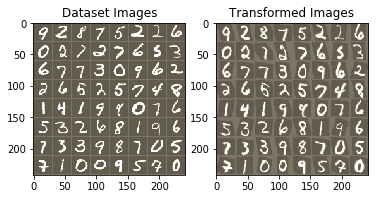

In [5]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    # Get a batch of training data
    data, _ = next(iter(test_loader))
    data = Variable(data, volatile=True)

    if use_cuda:
        data = data.cuda()

    input_tensor = data.cpu().data
    transformed_input_tensor = model.stn(data).cpu().data

    in_grid = convert_image_np(
        torchvision.utils.make_grid(input_tensor))

    out_grid = convert_image_np(
        torchvision.utils.make_grid(transformed_input_tensor))

    # Plot the results side-by-side
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset Images')

    axarr[1].imshow(out_grid)
    axarr[1].set_title('Transformed Images')


for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

# Neural Style Transfer

[Tutorial](http://pytorch.org/tutorials/advanced/neural_style_tutorial.html) doesn't seem to actually work

In [51]:
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [52]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [53]:
# desired size of the output image
imsize = 512 if use_cuda else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


style_img = image_loader("images/picasso.jpg").type(dtype)
content_img = image_loader("images/dancing.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

/Users/wanshenl/anaconda/lib/python3.5/site-packages/torchvision-0.2.0-py3.5.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


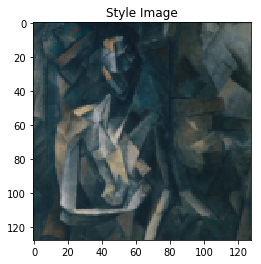

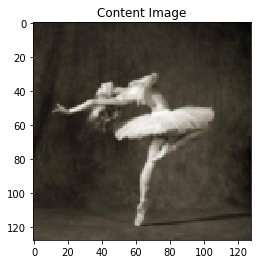

In [54]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

In [55]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input_):
        self.loss = self.criterion(input_ * self.weight, self.target)
        self.output = input_
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [56]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [57]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [58]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

In [59]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # the new Sequential module network
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses

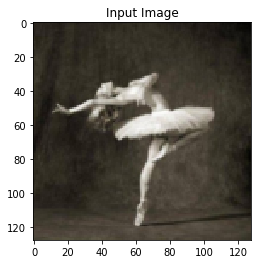

In [60]:
input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

# add the original input image to the figure:
plt.figure()
imshow(input_img.data, title='Input Image')


In [79]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.Adam([input_param])
    return input_param, optimizer


In [83]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()

            res = style_score + content_score
            return res

        optimizer.step(closure)

    # a last correction...
    input_param.data.clamp_(0, 1)

    return input_param.data

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1.409326 Content Loss: 1.479150

run [100]:
Style Loss : 1.308705 Content Loss: 1.407603

run [150]:
Style Loss : 1.202619 Content Loss: 1.335676

run [200]:
Style Loss : 1.097043 Content Loss: 1.271744

run [250]:
Style Loss : 0.995733 Content Loss: 1.213245

run [300]:
Style Loss : 0.900737 Content Loss: 1.161180



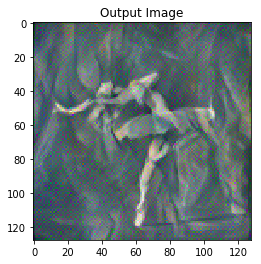

In [91]:
output = run_style_transfer(cnn, content_img, style_img, input_img)
# takes at least 300+600+300+600..
# ~= 2500 iterations to converge
# because of smaller input image??

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()